In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, BayesianRidge

import warnings
warnings.filterwarnings('ignore')

## Limpeza dos dados

Fase de limpeza e comparação dos dados.

In [2]:
train_df = pd.read_csv("/home/felipe/Documents/uf/IA/prova/house-pricing/train.csv", encoding='UTF-8')

In [3]:
train_df.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

Foram idenificadas 19 colunas que possuem células vazias. A quantidade de células vazias varia de uma coluna para outra. Serão descartadas as colunas com mais que 10 células vazias, as demais serão preenchidas com a moda da classe.

In [4]:
dropped_cls = []

for cl in train_df.columns:
    if train_df[cl].isnull().sum() > 10:
        dropped_cls.append(cl)
    else:
        train_df[cl].fillna(train_df[cl].mode()[0], inplace = True)
        
train_df.drop(dropped_cls, axis=1, inplace = True)

print(train_df.isnull().sum().max())

0


Feita o tratamento dos valores nulos, agora será feita a escolha das classes que farão parte do teste.

Essa escolha será feita de acordo com a correlação da classe com o resultado, considerando apenas as classes que possuem correlação maior que 0.2 com a classe _'SalePrice'_.

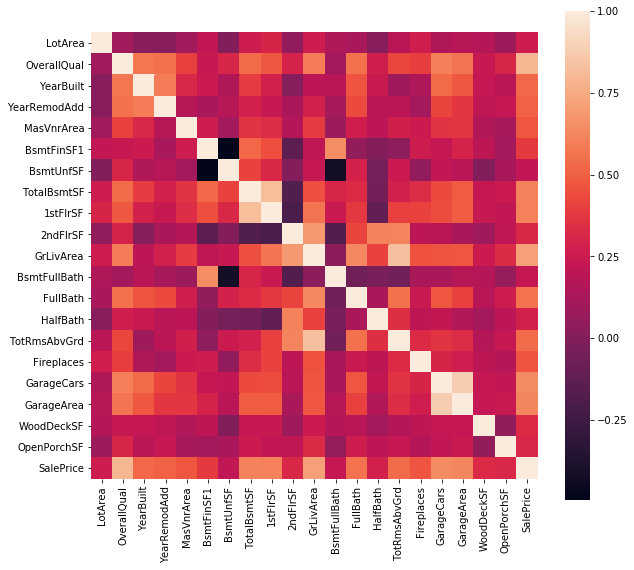

In [5]:
train_df = train_df._get_numeric_data()

cols = train_df.corr(method='pearson').index[abs(train_df.corr()["SalePrice"])>0.2]
corr_matrix = np.corrcoef(train_df[cols].values.T)

f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(corr_matrix, square=True, yticklabels=cols.values, xticklabels=cols.values)

Essas serão as classes consideradas para o teste.

In [6]:
train_df = train_df[cols]

train_df.describe()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,BsmtFullBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,6.099315,1971.267808,1984.865753,103.117123,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,0.425342,1.565068,0.382877,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,180921.195890
std,9981.264932,1.382997,30.202904,20.645407,180.731373,456.098091,441.866955,438.705324,386.587738,436.528436,...,0.518911,0.550916,0.502885,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,79442.502883
min,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,7553.500000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,0.000000,1.000000,0.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,129975.000000
50%,9478.500000,6.000000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,0.000000,2.000000,0.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000
75%,11601.500000,7.000000,2000.000000,2004.000000,164.250000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,1.000000,2.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000
max,215245.000000,10.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,3.000000,3.000000,2.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,755000.000000


Para a fase de testes a base é dividida em teste e treino.

In [7]:
train_data = [x for x in train_df.columns if x != 'SalePrice' and x != 'GarageArea']
train_target = ['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(train_df[train_data], train_df[train_target], test_size=0.35, random_state=0)

Nessa fase serão testados os aloritmos para avaliar o que possui menor erro médio.

### Gradient Boosting Regressor

In [8]:
def consecutive_gbr(learn_rate):
    GB_reg = GradientBoostingRegressor(n_estimators=100, loss='lad', learning_rate=learn_rate, random_state=0)
    GB_reg.fit(X_train, y_train)

    GBR_predict = GB_reg.predict(X_test)

    return metrics.mean_absolute_error(y_test, GBR_predict)

rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.01, 0.02, 0.03, 0.05, 0.06, 0.08, 0.09, 0.001]

results = []

for rate in rates:
    results.append((rate, consecutive_gbr(rate)))
    print("absolute mean error with rate", rate, ":", consecutive_gbr(rate))

best = min(results, key = lambda t: t[1])
print('\nbest iteration: learning_rate(', best[0],') mean error:', best[1])

absolute mean error with rate 0.1 : 16967.994643434093
absolute mean error with rate 0.2 : 17317.056480886324
absolute mean error with rate 0.3 : 17860.570827708092
absolute mean error with rate 0.4 : 18877.62358736777
absolute mean error with rate 0.5 : 20446.646162965346
absolute mean error with rate 0.01 : 33037.27910152252
absolute mean error with rate 0.02 : 24389.103454666172
absolute mean error with rate 0.03 : 20530.052465777153
absolute mean error with rate 0.05 : 17646.283898410682
absolute mean error with rate 0.06 : 17487.427303905628
absolute mean error with rate 0.08 : 17063.060046943723
absolute mean error with rate 0.09 : 17065.616003270174
absolute mean error with rate 0.001 : 51704.98893217912

best iteration: learning_rate( 0.1 ) mean error: 16967.994643434093


### Melhor resultado

Ao variar o parâmetro learning_rate, melhor valor de erro médio encontrado utilizando o **Gradient Boost foi 17576.24**, com o **learning_rate = 0.08**.

### Random Forest Regressor

In [9]:
def consecutive_rfg (max_leaves):
    RF_reg = RandomForestRegressor(max_leaf_nodes=max_leaves, random_state=0)
    RF_reg.fit(X_train, y_train)

    RFR_predict = RF_reg.predict(X_test)
    
    return metrics.mean_absolute_error(y_test, RFR_predict)

max_leaves = [5, 10, 50, 100, 300, 500, 1000, 2000]

results_rfg = []
for num_leaves in max_leaves:
    results_rfg.append((num_leaves, consecutive_rfg(num_leaves)))
    print("absolute mean error: leaves", num_leaves, ':', consecutive_rfg(num_leaves))

best_rfg = min(results_rfg, key = lambda t: t[1])
print('\nbest iteration: max_leaf_nodes(', best_rfg[0],') mean error:', best_rfg[1])

absolute mean error: leaves 5 : 30920.708672329332
absolute mean error: leaves 10 : 25273.40044237263
absolute mean error: leaves 50 : 19050.40239841025
absolute mean error: leaves 100 : 18866.481189444905
absolute mean error: leaves 300 : 18919.39081680601
absolute mean error: leaves 500 : 18949.88719612959
absolute mean error: leaves 1000 : 18947.469341161122
absolute mean error: leaves 2000 : 18947.469341161122

best iteration: max_leaf_nodes( 100 ) mean error: 18866.481189444905


### Melhor resultado

Ao variar o parâmetro de quantidade máxima de folhas no algoritmo **Random Forest, o melhor valor de erro médio encontrado foi de 19886**, com no **máximo 100 folhas**.